# Multimodal Classification Mobilenet V2  
moriitkys@ROBOTAiM  
LICENSE : MIT

RGB-ThermalデータをインプットとしてMobilenet v2をバックボーンとした画像分類の学習と推測を実行するプログラムです。  
It is a program that uses RGB-Thermal data as input to perform image classification learning and guessing with Mobilenet v2 as the backbone.   
マルチモーダル深層学習のチュートリアルなので、精度については期待できません。今後はネットワークの改良やマルチモーダルの有効な活用方法について検討し、プログラムを更新・新規追加していきます。  
It's a multimodal deep learning tutorial, so you can't expect accuracy. In the future, we will consider ways to improve the network and effectively utilize multimodal, and update and add new programs. 

In [1]:
import os
import glob
import shutil
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import tkinter
from tkinter import messagebox

import mylib.create_panel_for_mdlc as create_panel
import mylib.config as config
config_param = config.ConfigParameters()

# ----- Setting Parameters -----
f = open('./log/selected_folders_for_training.csv', 'r')
reader = csv.reader(f)
f_param = open('./log/params.csv', 'r')
reader_param = csv.reader(f_param)
list_selected_folders = []
dict_selected_folders = {}
dict_params = {}
var_sp_trainvalratio = 0.7
var_sp_epochs = 25
flag_train = True
batch_size_defined = config_param.batch_size_defined
img_size = config_param.img_size
type_backbone = "mobilenet_v2_rgbt"

for row in reader:
    #list_selected_folders.append(row[0])
    row[0] = row[0].replace("\\", "/")
    rslash_1st = row[0].rfind('/')
    rslash_2nd = row[0][:rslash_1st].rfind('/')
    object_class_number_name = row[0][rslash_2nd+1 :]
    dict_selected_folders[object_class_number_name] = row[0]
str_selected_folders = "\n".join(dict_selected_folders)

for row in reader_param:
    print(row)
    dict_params[row[0]] = row[1]
str_params = "\n".join([ key + " : " + dict_params[key] for key in dict_params ])

# ----- Yes・No Confirm Target Dir -----
root1 = tkinter.Tk()
# You can't use root1 = tkinter.withdraw()
text_message_window = "現在の学習対象フォルダと設定は以下が選択されています。\n"+\
                        "The following is selected as the current target folder and params for training.\n"+\
                        "処理対象フォルダを変更しますか。\n"+\
                        "Do you want to change the processing target folder or parameters?\n"+\
                        str_selected_folders + "\n" +\
                        str_params
ret = messagebox.askyesno('Confirm Target Dir', text_message_window)
root1.destroy()


# ----- [Main Process] Move Manual-Colored Data by using list_selected_folders -----
# Searching extention : "_c_raw_redmask.png"
key_for_searching_foldername = config_param.key_for_mdl
if ret:
    # ------ Setting panels ------
    setting_panel = create_panel.CreatePanel(key_for_searching_foldername)
    setting_panel.create_buttons()#If you push "start", exit this line.
    var_sp_trainvalratio = float(setting_panel.var_sp_trainvalratio.get())
    var_sp_epochs = int(setting_panel.var_sp_epochs.get())
    flag_train = setting_panel.flag_train
    dict_params["var_sp_trainvalratio"] = var_sp_trainvalratio
    dict_params["var_sp_epochs"] = var_sp_epochs
    dict_params["flag_train"] = flag_train
    
    list_selected_folders = setting_panel.list_selected_folders
    dict_selected_folders = setting_panel.dict_selected_folders
    print("list_selected_folders", "\n".join(list_selected_folders))
    #print("dict_selected_folders", dict_selected_folders)
else:
    for key in dict_selected_folders:
        list_selected_folders.append(dict_selected_folders[key])
        print("list_selected_folders", "\n".join(list_selected_folders))
        var_sp_trainvalration = float(dict_params["var_sp_trainvalratio"])
        var_sp_epochs = int(dict_params["var_sp_epochs"])
        flag_train = bool(dict_params["flag_train"])
for selected_folder in list_selected_folders:
    print(selected_folder)

# ----- How many classes are in "dataset" folder -----
#categories = dict_selected_folders
categories_idx = {}  # ex) HookWrench:0, SpannerWrench:1
i = 0
for key in dict_selected_folders:
    class_object_name = key[0:key.rfind("/")]
    print(class_object_name)
    if class_object_name not in categories_idx:
        categories_idx[class_object_name] = i
        i += 1
print(categories_idx)
nb_classes = len(categories_idx)  # ex) nb_classes=2
type_backbone = type_backbone + "_cls" + str(nb_classes)

# ----- flag_train == False, check nb_classes and weights shape

# ----- Write the path of list_selected_folders to csv -----
list_selected_folders = [ [i] for i in list_selected_folders]
f = open('./log/selected_folders_for_training.csv','w')
# https://work-life-enj.com/pyhon-write-csv/
w = csv.writer(f, lineterminator='\n')
w.writerows(list_selected_folders)
#for i in list_selected_folders:
#    w.writerow(i)
f.close()

# ----- Write the path of list_selected_folders to csv -----
list_params = [ [key, dict_params[key]] for key in dict_params]
f_params = open('./log/params.csv','w')
# https://work-life-enj.com/pyhon-write-csv/
w = csv.writer(f_params, lineterminator='\n')
w.writerows(list_params)
f_params.close()

['var_sp_trainvalratio', '0.7']
['var_sp_epochs', '25']
['flag_train', 'True']
list_selected_folders F:/rgbdt_dataset_imgs/food_apple/0001_aug
list_selected_folders F:/rgbdt_dataset_imgs/food_apple/0001_aug
F:/rgbdt_dataset_imgs/food_banana/0001_aug
list_selected_folders F:/rgbdt_dataset_imgs/food_apple/0001_aug
F:/rgbdt_dataset_imgs/food_banana/0001_aug
F:/rgbdt_dataset_imgs/food_bread_hight/0001_aug
list_selected_folders F:/rgbdt_dataset_imgs/food_apple/0001_aug
F:/rgbdt_dataset_imgs/food_banana/0001_aug
F:/rgbdt_dataset_imgs/food_bread_hight/0001_aug
F:/rgbdt_dataset_imgs/food_bread_lowt/0002_aug
list_selected_folders F:/rgbdt_dataset_imgs/food_apple/0001_aug
F:/rgbdt_dataset_imgs/food_banana/0001_aug
F:/rgbdt_dataset_imgs/food_bread_hight/0001_aug
F:/rgbdt_dataset_imgs/food_bread_lowt/0002_aug
F:/rgbdt_dataset_imgs/food_butter_roll_hight/0001_aug
list_selected_folders F:/rgbdt_dataset_imgs/food_apple/0001_aug
F:/rgbdt_dataset_imgs/food_banana/0001_aug
F:/rgbdt_dataset_imgs/food_bre

# Prepare Dataset データセットの準備
ファイルパスとそのクラスをペアとしてすべて保持するためにDataFrameを使う。  
ImageDataGeneratorを使う。  

In [2]:
# https://qiita.com/taichinakabeppu/items/74a27401cae0d0076941
#pip install keras==2.2.2
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random

# Use DataFrame to keep all file paths and their classes as a pair 
dataframe_selected_folders = pd.DataFrame({'x_col': [],'y_col': []}, index = None)
df_train = pd.DataFrame({'x_col': [],'y_col': []}, index = None)
df_val = pd.DataFrame({'x_col': [],'y_col': []}, index = None)
paths = []
labels = []
dict_data_volumes = {}
#dataframe_selected_folders.columns = ["x_col", "y_col"]
for key in dict_selected_folders:  # Prepare Training Dataset
    #print(key)
    class_object_name = key[0:key.rfind("/")]
    label = categories_idx[class_object_name]

    object_class_number_path = dict_selected_folders[key]
    #print(object_class_number_path)
    
    files = glob.glob(object_class_number_path + "/*_c.png")
    
    paths.extend(files)
    labels.extend([ class_object_name for i in range(len(files))])
    if categories_idx[class_object_name] in dict_data_volumes:
        dict_data_volumes[categories_idx[class_object_name]] += len(files)
    else:
        dict_data_volumes[categories_idx[class_object_name]] = len(files)
    #print(len(paths))
    #print(len(labels))
    
# ----- Calculate Class Weights -----
#https://qiita.com/hiden_no_tare/items/3415b14c077cbfdadaea
max_data_volume = float(max([ dict_data_volumes[i] for i in dict_data_volumes ]))
for key in dict_data_volumes:
    dict_data_volumes[key] = max_data_volume / dict_data_volumes[key]
print(dict_data_volumes)


df = pd.DataFrame({"x_col": paths, "y_col": labels})
#print(df)
dataframe_selected_folders = dataframe_selected_folders.append(df)
    
#print(dataframe_selected_folders)
df_shuffled=dataframe_selected_folders.iloc[np.random.permutation(dataframe_selected_folders.index)].reset_index(drop=True)

df_train = df_shuffled[:int(len(df_shuffled)*var_sp_trainvalratio)]
df_val = df_shuffled[int(len(df_shuffled)*var_sp_trainvalratio):]

df_train.to_csv('df_train.csv')

#print(df_train)
#print(df_val)

# https://www.kumilog.net/entry/keras-generator
class ImageDataGenerator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.labels = []

    def flow_from_directory(self, df, categories_idx, batch_size=batch_size_defined):
        # LabelEncode(classをint型に変換)するためのdict
        #classes = {v: i for i, v in enumerate(sorted(classes))}
        
        #x_train = np.empty(shape=[0, 224, 224, 4])
        #x_val = np.empty(shape=[0, 224, 224, 4])
        #y_train = np.empty(shape=[0])
        #y_val = np.empty(shape=[0])
        
        img_rgb = None

        while True:
            for df_row in range(len(df)):
                imgfile = df.iloc[df_row][0]
                class_object_name = df.iloc[df_row][1]
                
                # Load color data
                img_rgb = load_img(imgfile, target_size=(img_size[0], img_size[1]))
                img_rgb = img_to_array(img_rgb) / 255.

                # Load thermal data
                imgfile_t = imgfile.replace("_c.png", "_t.png")
                img_t = load_img(imgfile_t, grayscale=True, target_size=(img_size[0], img_size[1]))
                img_t = img_to_array(img_t) / 255.

                img_rgbt = np.append(img_rgb, img_t, axis=2)

                array = img_rgbt[np.newaxis, :, :, :]

                #self.images = np.r_[self.images, array]
                #self.labels = np.r_[self.labels, label]

                self.images.append(img_rgbt)
                self.labels.append(to_categorical(categories_idx[class_object_name], len(categories_idx)))

                # ここまでを繰り返し行い、batch_sizeの数だけ配列(self.iamges, self.labels)に格納
                # batch_sizeの数だけ格納されたら、戻り値として返し、配列(self.iamges, self.labels)を空にする
                if len(self.images) == batch_size:
                    inputs = np.asarray(self.images, dtype=np.float32)
                    targets = np.asarray(self.labels, dtype=np.float32)
                    self.reset()
                    yield inputs, targets

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()



C:\Users\rbpc2\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


{0: 2.627450980392157, 1: 2.09375, 2: 2.4363636363636365, 3: 4.1875, 4: 2.9558823529411766, 5: 1.8873239436619718, 6: 2.0, 7: 2.2333333333333334, 8: 2.09375, 9: 1.0, 10: 3.5892857142857144, 11: 1.9142857142857144, 12: 3.140625, 13: 2.7916666666666665, 14: 1.5227272727272727}


# Define a deep learning model

In [3]:
import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM
from keras.layers.pooling import GlobalAveragePooling2D

############################################################
#  MobileNetV2 Graph
############################################################

# Code adpated from:
# https://github.com/xiaochus/MobileNetV2/blob/master/mobilenet_v2.py

"""MobileNet v2 models for Keras.
# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""
class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.

    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when inferencing
        """
        return super(self.__class__, self).call(inputs, training=training)


def relu6(x):
    return K.relu(x, max_value=6)


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1),block_id=1, train_bn=False):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = KL.Conv2D(filters, kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv{}'.format(block_id))(inputs)
    x = BatchNorm(axis=channel_axis, name='conv{}_bn'.format(block_id))(x, training = train_bn)
    return KL.Activation(relu6, name='conv{}_relu'.format(block_id))(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1, train_bn=False):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)
    # Depthwise
    x = KL.DepthwiseConv2D((3, 3),
                    padding='same',
                    depth_multiplier=depth_multiplier,
                    strides=strides,
                    use_bias=False,
                    name='conv_dw_{}'.format(block_id))(inputs)
    x = BatchNorm(axis=channel_axis, name='conv_dw_{}_bn'.format(block_id))(x, training=train_bn)
    x = KL.Activation(relu6, name='conv_dw_{}_relu'.format(block_id))(x)
    # Pointwise
    x = KL.Conv2D(pointwise_conv_filters, (1, 1),
                    padding='same',
                    use_bias=False,
                    strides=(1, 1),
                    name='conv_pw_{}'.format(block_id))(x)
    x = BatchNorm(axis=channel_axis, name='conv_pw_{}_bn'.format(block_id))(x, training=train_bn)
    return KL.Activation(relu6, name='conv_pw_{}_relu'.format(block_id))(x)

def _bottleneck(inputs, filters, kernel, t, s, r=False, alpha=1.0, block_id=1, train_bn = False):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t
    filters = int(alpha * filters)

    x = _conv_block(inputs, tchannel, alpha, (1, 1), (1, 1),block_id=block_id,train_bn=train_bn)

    x = KL.DepthwiseConv2D(kernel,
                    strides=(s, s),
                    depth_multiplier=1,
                    padding='same',
                    name='conv_dw_{}'.format(block_id))(x)
    x = BatchNorm(axis=channel_axis,name='conv_dw_{}_bn'.format(block_id))(x, training=train_bn)
    x = KL.Activation(relu6, name='conv_dw_{}_relu'.format(block_id))(x)

    x = KL.Conv2D(filters,
                    (1, 1),
                    strides=(1, 1),
                    padding='same',
                    name='conv_pw_{}'.format(block_id))(x)
    x = BatchNorm(axis=channel_axis, name='conv_pw_{}_bn'.format(block_id))(x, training=train_bn)

    if r:
        x = KL.add([x, inputs], name='res{}'.format(block_id))
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n, alpha, block_id, train_bn):
    x = _bottleneck(inputs, filters, kernel, t, strides, False, alpha, block_id, train_bn)

    for i in range(1, n):
        block_id += 1
        x = _bottleneck(x, filters, kernel, t, 1, True, alpha, block_id, train_bn)

    return x


def mobilenetv2_graph(inputs,  alpha = 1.0, train_bn = False):
    x      = _conv_block(inputs, 64, alpha, (3, 3), strides=(2, 2), block_id=0, train_bn=train_bn)                      # Input Res: 1
    C1 = x = _inverted_residual_block(x, 32,  (3, 3), t=1, strides=1, n=1, alpha=1.0, block_id=1, train_bn=train_bn)	# Input Res: 1/2
    C2 = x = _inverted_residual_block(x, 24,  (3, 3), t=6, strides=2, n=2, alpha=1.0, block_id=2, train_bn=train_bn)	# Input Res: 1/2
    C3 = x = _inverted_residual_block(x, 32,  (3, 3), t=6, strides=2, n=3, alpha=1.0, block_id=4, train_bn=train_bn)	# Input Res: 1/4
    x      = _inverted_residual_block(x, 64,  (3, 3), t=6, strides=2, n=4, alpha=1.0, block_id=7, train_bn=train_bn)	# Input Res: 1/8
    C4 = x = _inverted_residual_block(x, 96,  (3, 3), t=6, strides=1, n=3, alpha=1.0, block_id=11, train_bn=train_bn)	# Input Res: 1/8
    x      = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3, alpha=1.0, block_id=14, train_bn=train_bn)	# Input Res: 1/16
    C5 = x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1, alpha=1.0, block_id=17, train_bn=train_bn)	# Input Res: 1/32
    x = _conv_block(x, 1280, alpha, (1, 1), strides=(1, 1), block_id=18, train_bn=train_bn)                            # Input Res: 1/32
    x = GlobalAveragePooling2D()(x)
    x = KL.Dense(1024, activation = 'relu')(x)
    return x

# Build the model and execute training

Epoch 1/25


C:\Users\rbpc2\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:108: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


488/488 [==============================] - 587s 1s/step - loss: 3.7726 - acc: 0.4143 - val_loss: 1.0154 - val_acc: 0.6691
Epoch 2/25
488/488 [==============================] - 602s 1s/step - loss: 1.3188 - acc: 0.7564 - val_loss: 0.4824 - val_acc: 0.8349
Epoch 3/25
488/488 [==============================] - 613s 1s/step - loss: 0.6676 - acc: 0.8726 - val_loss: 0.2986 - val_acc: 0.9065
Epoch 4/25
488/488 [==============================] - 603s 1s/step - loss: 0.3793 - acc: 0.9340 - val_loss: 0.1769 - val_acc: 0.9480
Epoch 5/25
488/488 [==============================] - 601s 1s/step - loss: 0.2331 - acc: 0.9621 - val_loss: 0.1265 - val_acc: 0.9626

Epoch 00005: saving model to weights_keras/mobilenet_v2_rgbt_cls15/cp_0005.hdf5
Epoch 6/25
488/488 [==============================] - 614s 1s/step - loss: 0.1559 - acc: 0.9756 - val_loss: 0.0935 - val_acc: 0.9725
Epoch 7/25
488/488 [==============================] - 620s 1s/step - loss: 0.1082 - acc: 0.9847 - val_loss: 0.0653 - val_acc: 0.9823

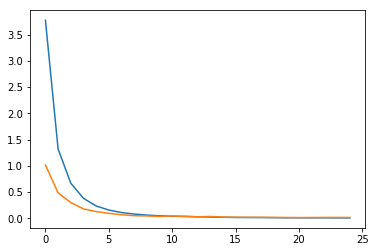

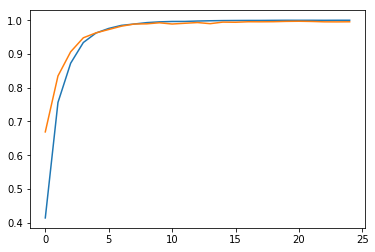

In [4]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import np_utils
from keras.utils import to_categorical

total_epochs = var_sp_epochs

output_folder = "out_"+type_backbone
if os.path.exists(output_folder) == False:
    os.makedirs(output_folder)

input_image = KL.Input(
                shape=[None, None, 4], name="input_image")

model_mvnet = mobilenetv2_graph(input_image,  alpha=1.0, train_bn=True)
model_output = KL.Dense(nb_classes, activation='softmax')(model_mvnet)

model = keras.Model(inputs=input_image, outputs=model_output)

# Compile the model
model.compile(
    optimizer = SGD(lr=0.001),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

#model.summary()


if flag_train == True:
    if os.path.exists("weights_keras/"+type_backbone) == False:
        os.makedirs("weights_keras/"+type_backbone)
    checkpoint_path = "weights_keras/"+type_backbone+"/cp_{epoch:04d}.hdf5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        verbose = 1,
        save_weights_only = True,
        period = 5)#Save the weights per 10 epochs

    model.save_weights(checkpoint_path.format(epoch=0))

    history = model.fit_generator(
        generator=train_datagen.flow_from_directory(df_train, categories_idx),
        steps_per_epoch=int(np.ceil(len(df_train) / batch_size_defined)),
        epochs=total_epochs,
        class_weight=dict_data_volumes, 
        verbose=1,
        validation_data=val_datagen.flow_from_directory(df_val, categories_idx),
        validation_steps=int(np.ceil(len(df_val) / batch_size_defined)),
        callbacks = [cp_callback])

    #score=model.evaluate(x_val1,y_val1,verbose=0)
    #print("val loss : ",score[0])
    #print("val acc : ",score[1])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.savefig(output_folder+"/graph_loss_rgbt.png")
    plt.show()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.savefig(output_folder+"/graph_acc_rgbt.png")
    plt.show()

else:
    weights_folder_path = "weights_keras/"+type_backbone+"/"
    files = os.listdir(weights_folder_path)
    best_weights_path = max(files)# use the last weights
    best_weights_path = "weights_keras/"+type_backbone+"/" + best_weights_path 
    print(best_weights_path)
    model.load_weights(best_weights_path)
    print("loaded weights")

# Inference

0
./test/food_apple\img0001_c.png
1
./test/food_banana\img0001_c.png
2
./test/food_bread_hight\img_02639_c.png
3
./test/food_bread_lowt\img0003_c.png
4
./test/food_butter_roll_hight\img0004_c.png
5
./test/food_butter_roll_lowt\img0001_c.png
9
./test/industrial_bolt\img0002_c.png
10
./test/industrial_caliper\img_00049_c.png
11
./test/industrial_tool_holder\img_00034_c.png
12
./test/industrial_tool_milling\img_00040_c.png
13
./test/industrial_vice\img0004_c.png
14
./test/industrial_wrench_spanner\img0001_c.png


C:\Users\rbpc2\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:108: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


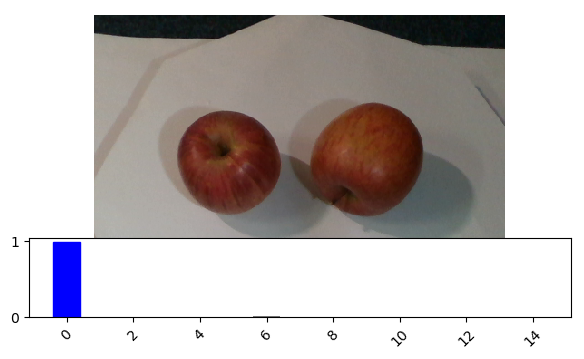

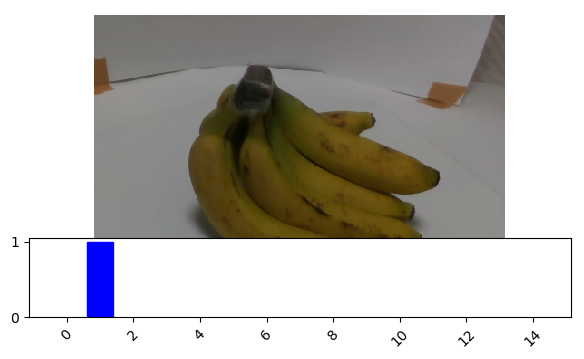

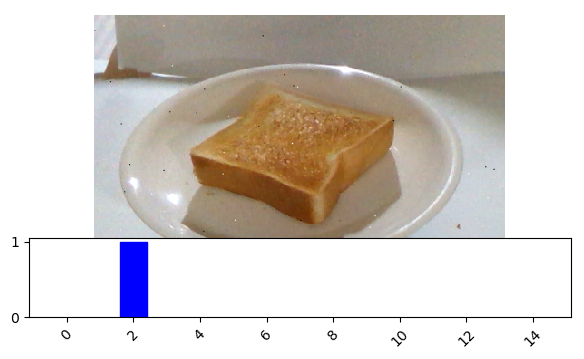

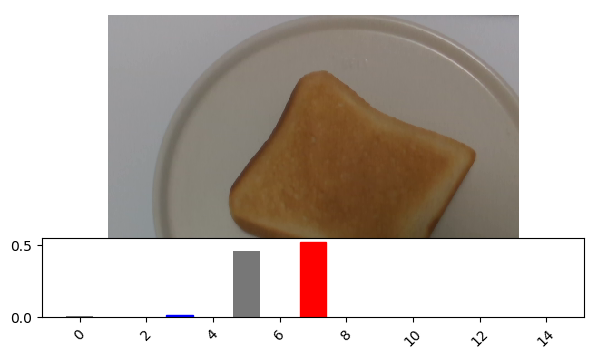

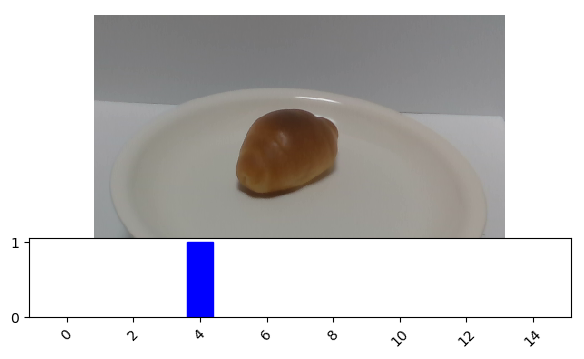

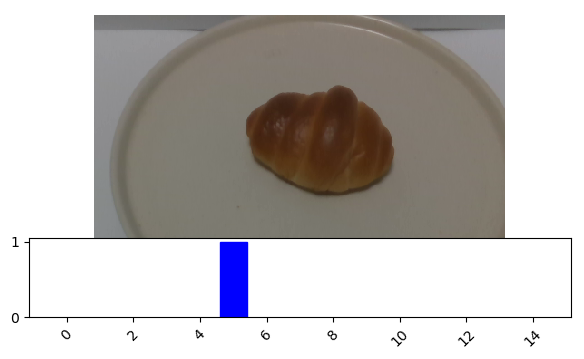

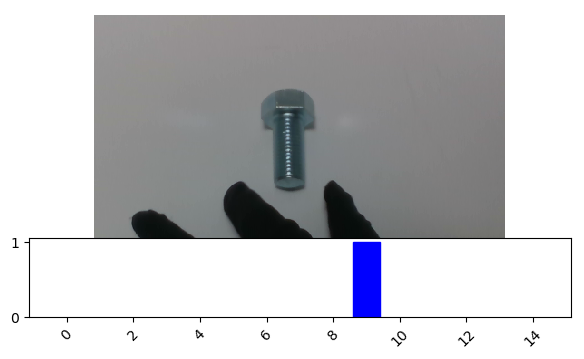

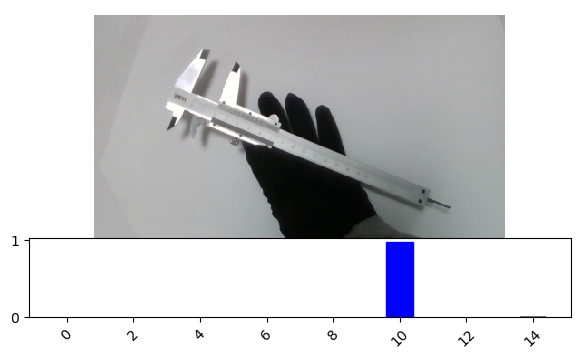

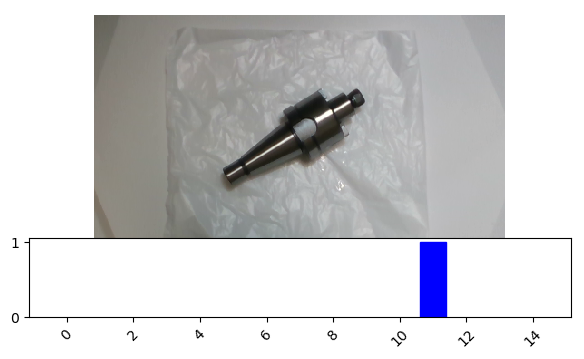

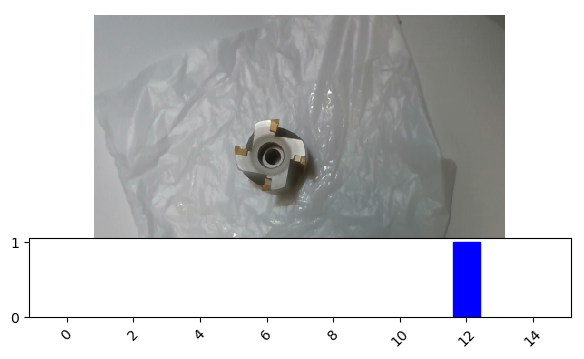

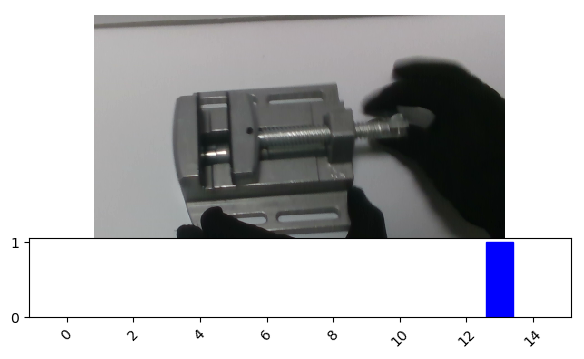

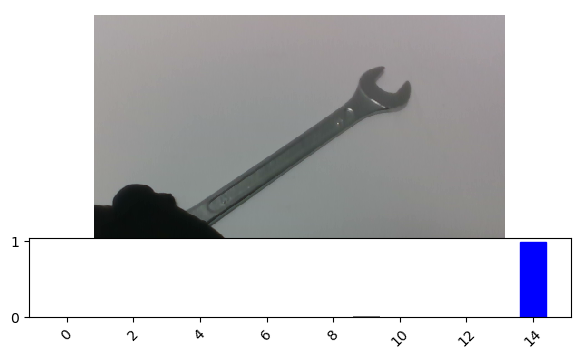

In [7]:
# Inference test images
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

#categories = [ categories_idx[i] for i in categories_idx]f
categories = [ i for i in categories_idx]
#print(categories)
class_object_folders = glob.glob("./test/*")

x_test = np.empty(shape=[0, 224, 224, 4])

for class_object in class_object_folders:
    class_object = class_object.replace("\\", "/")
    true_label = categories_idx[class_object[class_object.rfind("/")+1:]]
    print(true_label)
    files_test = glob.glob(class_object+"/*_c.png")
    for imgfile in files_test:
        print(imgfile)
        img_rgb = None
        
        img_rgb = load_img(imgfile, target_size=(img_size[0], img_size[1]))
        img_rgb = img_to_array(img_rgb) / 255.

        imgfile_t = imgfile.replace("_c.png", "_t.png")
        img_t = load_img(imgfile_t, grayscale=True, target_size=(img_size[0], img_size[1]))
        img_t = img_to_array(img_t) / 255.
        
        img_rgbt = np.append(img_rgb, img_t, axis=2)
        
        #img_rgbd = np.r_[img_rgb, img_d]
        #print(img_rgbd.shape)
        #array = img_to_array(img_rgbd) / 255
        #array = img_rgbd[np.newaxis, :, :, :]
        x_test = np.r_[x_test, img_rgbt[np.newaxis, :, :, :]]
        
        #x_test = img_rgb[np.newaxis, :, :, :]
        #x_test=img_rgbd
plobs_pred = model.predict(x_test)# inference
#print(plobs_pred)

pred_classes = np.argmax(plobs_pred, axis = 1)
x = np.array(img_rgb)

k = 1
for class_object in class_object_folders:
    class_object = class_object.replace("\\", "/")
    true_label = categories_idx[class_object[class_object.rfind("/")+1:]]
    #print(true_label)
    files_test = glob.glob(class_object+"/*_c.png")
    for imgfile in files_test:
        num_tests = len(files_test)

        test_img = cv2.imread(imgfile)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

        fig = plt.figure(figsize = (7,4), dpi= 100)

        gs_master = GridSpec(nrows = 2, ncols = 1, height_ratios = (2.5,1))
        gs = [0]*2
        gs[0] = GridSpecFromSubplotSpec(nrows = 1, ncols = 1, subplot_spec = gs_master[0:2, 0:2])
        gs[1] = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, subplot_spec = gs_master[1, 0])
        ax = [0]*2
        for j in range(len(gs)):
            ax[j] = fig.add_subplot(gs[j][:,:])

        ax[0].imshow(np.asarray(test_img))
        ax[0].axis('off')

        predictions_array, true_label =  plobs_pred[k-1], true_label
        predicted_label = np.argmax(predictions_array)
        #thisplot = ax[1].bar(categories, predictions_array, color="#777777")
        thisplot = ax[1].bar(range(nb_classes), predictions_array, color="#777777")
        plt.xticks(rotation=45)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
        if os.path.exists(output_folder +"/out_all/") == False:
            os.makedirs(output_folder +"/out_all/")
        plt.savefig(output_folder+"/out_all/"+str(k) + 'figure.png')
        plt.show()

        k += 1

In [15]:


files = glob.glob("./test/*_c.png")
x_test = np.empty(shape=[0, 224, 224, 4])

for imgfile in files:
    #print(imgfile)
    img_rgb = load_img(imgfile, target_size=(img_size[0], img_size[1]))
    img_rgb = img_to_array(img_rgb) / 255
    #imgfile_d = imgfile[:-6] + "_d.png"
    imgfile_d = imgfile.replace("_c.png", "_d.png")
    img_d = load_img(imgfile_d, grayscale=True, target_size=(img_size[0], img_size[1]))
    img_d = img_to_array(img_d) / 255
    #img_d = img_d[:,:,np.newaxis]
    #print(img_rgb.shape, img_d.shape)
    img_rgbd = np.append(img_rgb, img_d, axis=2)
    #img_rgbd = np.r_[img_rgb, img_d]
    #print(img_rgbd.shape)
    #array = img_to_array(img_rgbd) / 255
    array = img_rgbd[np.newaxis, :, :, :]
    x_test = np.r_[x_test, array]
    #y_test = np.r_[y_test, label]
    
def get_key(my_dict, val):
    return_value = "None"
    for key, value in my_dict.items():
        if val == value:
            return_value = key
    return return_value

    
preds = model.predict(x_test)
for i in preds:
    pred_index = np.argmax(i)
    print(get_key(categories_idx, pred_index))
    
    
    
    

    

industrial_wrench_spanner


In [1]:
import numpy as np

a = np.ones((1, 3,224,224))

b = np.empty((1, 3, 224, 224))
#print(a, b)

for i in range(10000):
    if i % 100 == 0: print(i)
    if i == 0:
        b = a
    else:
        b = np.append(b, a, axis=0)
    
print(a.shape, b.shape)

#print(b)



0
100
200
300
400


KeyboardInterrupt: 

In [6]:
a = {"aaa":1, "bbb":"2"}

for i,j in a:
    print(i,j)

ValueError: too many values to unpack (expected 2)

In [13]:
import pandas as pd
import numpy as np

dates=['April-10', 'April-11', 'April-12', 'April-13']
fruits=['Apple', 'Papaya', 'Banana', 'Mango']
prices=[3, 1, 2, 4]

df = pd.DataFrame({'Date':dates ,
                   'Fruit':fruits ,
                   'Price': prices})

df_shuffled=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
print(df_shuffled)

for i in range(len(df)):
    print(df["Date"][i])

       Date   Fruit  Price
0  April-13   Mango      4
1  April-12  Banana      2
2  April-10   Apple      3
3  April-11  Papaya      1
April-10
April-11
April-12
April-13


In [ ]:
# --- Make train path list ---
f_train = open('list_train.txt', 'w')
f_val = open('list_val.txt', 'w')
for key in dict_selected_folders:  # Prepare Training Dataset
    print(key)
    class_object_name = key[0:key.rfind("/")]
    label = categories_idx[class_object_name]

    object_class_number_path = dict_selected_folders[key]

    files = glob.glob(object_class_number_path + "/*_c.png")
    print(files[:10])
    
    for file in files:
        if random.random() <= radio_value_split:
            f_train.write(file.replace("\\", "/"))
        else:
            f_val.write(file.replace("\\", "/"))
f_train.close()
f_val.close()